<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/240726_sentinel2_analysis_valle_nuevo_national_park.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from ipyleaflet import TileLayer
from google.colab import files

ee.Authenticate()
ee.Initialize(project='ee-foss4g')

In [2]:
# Valle Nuevo National Park
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
wdpa = wdpa.filter(ee.Filter.eq('WDPAID', 478142))

wdpa_name = wdpa.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Valle Nuevo


In [3]:
m = geemap.Map(width="800px", height="400px")
m.addLayer(wdpa, {'color': 'green'}, wdpa_name)
m.centerObject(wdpa, 10)
m

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
def mask_s2_clouds(image):
    # Use QA (Quality Assurance) band for cloud masking in Sentinel-2
    qa = image.select('QA60')

    # Bit 10 is for clouds, Bit 11 is for cirrus clouds
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Consider clear if both cloud and cirrus bits are 0
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000) # Scaling

In [56]:
s2_images = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2023-03-16", "2023-03-31")
    .filterBounds(wdpa)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
    .map(mask_s2_clouds)
)

image_count = s2_images.size()

print("Image count:", image_count.getInfo())

Image count: 3


In [57]:
s2_image = s2_images.median()

In [55]:
s2_image = ee.Image(s2_images.toList(s2_images.size()).get(1))

In [37]:
# 1: Pixel value for the outline, 2: Thickness of the outline (in pixels)
wdpa_raster = ee.Image().paint(wdpa, 1, 2)

# Set visualization parameters
wdpa_vis = {
    'palette': ['#FFFF00'], # Apply Yellow color
    'opacity': 1
}

In [58]:
# TCC
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map(width="800px", height="400px")
m.add_layer(s2_image, vis_params, 'TCC')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.centerObject(wdpa, 10)
m

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

In [61]:
#FCC
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B8', 'B4', 'B3'],
}

m = geemap.Map(width="800px", height="400px")
m.add_layer(s2_image, vis_params, 'FCC')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.centerObject(wdpa, 10)
m

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

In [60]:
s2_image = s2_image.clip(wdpa.geometry())

### 3.1.3. 국립공원 경계 내에서 NDVI 계산 및 통계치 산출

In [62]:
# NDVI 계산: (NIR - Red) / (NIR + Red)
ndvi = s2_image.normalizedDifference(['B8', 'B4'])

In [63]:
# NDVI 색상 팔레트 정의
ndvi_palette = [
    'FE8374',  # 낮은 NDVI - 갈색
    'FED976',  # 낮은-중간 NDVI - 밝은 녹색
    'CAE23C',  # 중간 NDVI - 녹색
    '98B718',  # 중간-높은 NDVI - 진한 녹색
    '059033',  # 높은 NDVI - 매우 진한 녹색
]

m = geemap.Map(width="800px", height="400px")
m.add_layer(ndvi, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.centerObject(wdpa, 10)
m

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

In [64]:
# NDVI 통계치 계산 (최소값, 평균, 중간값, 최대값, 표준편차)
stats = ndvi.reduceRegion(
    reducer=ee.Reducer.min()
    .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.median(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.max(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
    geometry=wdpa.geometry(),
    scale=10,
    maxPixels=1e9,
)

# 통계치 결과를 DataFrame으로 변환
df_stats = pd.DataFrame(
    [stats.getInfo()],
    columns=["nd_min", "nd_mean", "nd_median", "nd_max", "nd_stdDev"],
    index=["VN"],
)
df_stats.columns = ["Min", "Mean", "Median", "Max", "StdDev"]
df_stats

,Min,Mean,Median,Max,StdDev
VN,-0.701068,0.666756,0.753985,1,0.195951


In [65]:
# Hansen Global Forest Change v1.10 (2000-2022) 데이터셋
gfc = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# 수관피복 시각화 파라미터
tree_cover_vis = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['black', 'green']
}

# 산림손실 시각화 파라미터
tree_loss_vis = {
    'bands': ['lossyear'],
    'min': 0,
    'max': 22,
    'palette': ['yellow', 'red']
}

In [66]:
# gfc 레이어 추가
m = geemap.Map(width="800px", height="400px")
m.addLayer(gfc, tree_cover_vis, 'tree cover')
m.addLayer(gfc, tree_loss_vis, 'tree loss year')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.centerObject(wdpa, 10)
m # 지도 객체 출력

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

### 3.2.3. 산림손실 면적 계산 및 시각화

In [67]:
# 산림손실 이미지
loss_image = gfc.select(['loss'])
area_image = loss_image.multiply(ee.Image.pixelArea())

# 설악산 BR 내 산림손실 면적 합산
stats = area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=wdpa.geometry(),
    scale=30,
    maxPixels=1e9,
)

# 산림손실 면적 출력
loss_area = stats.get('loss').getInfo()
print(f"산림손실 면적: {loss_area:.2f}m²")

산림손실 면적: 52273348.65m²


In [69]:
# 산림손실연도 이미지
lossyear_image = gfc.select(['lossyear'])

# 2001-2022년 산림손실 면적 계산
years = range(1, 23)
loss_areas = []

for year in years:
    # 해당 연도의 산림손실 픽셀 선택
    yearly_loss = lossyear_image.eq(year)

    # 산림손실 면적 계산
    area_image = yearly_loss.multiply(ee.Image.pixelArea())
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=wdpa.geometry(),
        scale=30,
        maxPixels=1e9,
    )

    # 연도별 손실 면적을 리스트에 추가 (단위: 제곱미터)
    loss_area = stats.getInfo()['lossyear']
    loss_areas.append(loss_area)

# 연도와 손실 면적을 데이터프레임으로 변환
df = pd.DataFrame({
    'Year': range(2001, 2023),
    'Loss_Area_m2': loss_areas
})

df['Loss_Area_ha'] = df['Loss_Area_m2'] / 10000
df.head(1)

,Year,Loss_Area_m2,Loss_Area_ha
0,2001,2.114148e+06,211.414826


In [73]:
# Create the new record as a DataFrame
new_record = pd.DataFrame({'Year': [2023], 'Loss_Area_m2': [38200000], 'Loss_Area_ha': [3820]})

# Concatenate the new record with the original DataFrame
df = pd.concat([df, new_record], ignore_index=True)

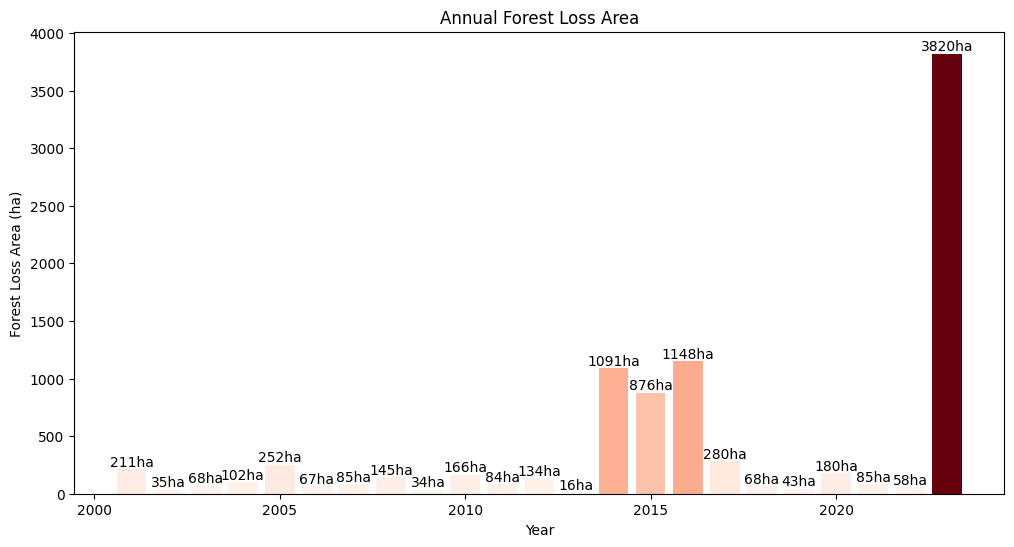

In [74]:
# 연도별 산림손실 면적 막대 그래프 생성
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Reds(df['Loss_Area_ha'] / df['Loss_Area_ha'].max())
bars = ax.bar(df['Year'], df['Loss_Area_ha'], color=colors)

# 막대 위에 헥타르 단위로 면적 표시
for bar, area_ha in zip(bars, df['Loss_Area_ha']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{area_ha:.0f}ha', va='bottom', ha='center', color='black')

# 레이블 설정
ax.set_xlabel('Year')
ax.set_ylabel('Forest Loss Area (ha)')
ax.set_title('Annual Forest Loss Area')

# 차트를 이미지로 저장
plt.savefig('forest_loss_area_colored.png', dpi=100)
plt.show()